## Monet painting GANs model

In this mini-project, my goal is to train a deep learning model that can make new images that look like Monet paintings. Instead of predicting labels or classes, I use a Generative Adversarial Network (GAN). In a GAN, the generator takes random noise (a latent vector) and tries to turn it into a Monet-style image, while the discriminator looks at images and tries to tell if they are real Monet paintings from the dataset or fake ones made by the generator. As they train against each other, the generator slowly learns to make images that look more and more like the real Monet paintings. Kaggle then scores the quality of these generated images using a metric called MiFID (Memorization-informed Fréchet Inception Distance), where a lower score means better, more realistic images that are not just memorized copies.
The dataset has color images of real Monet paintings and regular landscape photos. The images are stored as RGB files in two separate folders: one for Monet paintings and one for photos. In my code, each image is loaded as a 3-channel tensor (height × width × 3), and I resize everything to a fixed square size so it can go into my convolutional neural networks. The Monet images define the “target style” that the generator is trying to imitate, while the photo images can be used as another domain if I want to explore style-transfer ideas later.
Because all the data is image-based and can be resized to the same shape, it works well with convolutional GANs and makes it easier for the model to learn patterns in color, texture, and style.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from PIL import Image

In [2]:
from google.colab import files
uploaded = files.upload()


Saving photo_jpg.zip to photo_jpg.zip
Saving monet_jpg.zip to monet_jpg.zip


In [3]:
import os

print(os.listdir())


['.config', 'photo_jpg.zip', 'monet_jpg.zip', 'sample_data']


In [4]:
!unzip -q monet_jpg.zip
!unzip -q photo_jpg.zip

In [5]:
!unzip -o -q "monet_jpg.zip" -d monet_jpg
!unzip -o -q "photo_jpg.zip" -d photo_jpg


In [6]:
import os

MONET_PATH = "/content/monet_jpg"
PHOTO_PATH = "/content/photo_jpg"

print("Monet folder exists:", os.path.exists(MONET_PATH))
print("Photo folder exists:", os.path.exists(PHOTO_PATH))


Monet folder exists: True
Photo folder exists: True


In [7]:
from glob import glob

monet_files = sorted(glob(os.path.join(MONET_PATH, "*.jpg")))
photo_files = sorted(glob(os.path.join(PHOTO_PATH, "*.jpg")))

print("Number of Monet images:", len(monet_files))
print("Number of Photo images:", len(photo_files))

print("Sample Monet file:", monet_files[:2])
print("Sample Photo file:", photo_files[:2])

Number of Monet images: 300
Number of Photo images: 7038
Sample Monet file: ['/content/monet_jpg/000c1e3bff.jpg', '/content/monet_jpg/011835cfbf.jpg']
Sample Photo file: ['/content/photo_jpg/00068bc07f.jpg', '/content/photo_jpg/000910d219.jpg']


In [8]:
#preprocessing
def load_and_preprocess_image(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [64, 64])
    img = (tf.cast(img, tf.float32) / 127.5) - 1.0
    return img

In [9]:
monet_ds = tf.data.Dataset.from_tensor_slices(monet_files)
photo_ds = tf.data.Dataset.from_tensor_slices(photo_files)

monet_ds = monet_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
photo_ds = photo_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

monet_ds = monet_ds.shuffle(300).batch(1)
photo_ds = photo_ds.shuffle(300).batch(1)

print("Monet dataset:", monet_ds)
print("Photo dataset:", photo_ds)

# inspect one example
img = Image.open(monet_files[0])
print("Example Monet image size:", img.size)  # (width, height)

Monet dataset: <_BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>
Photo dataset: <_BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>
Example Monet image size: (256, 256)


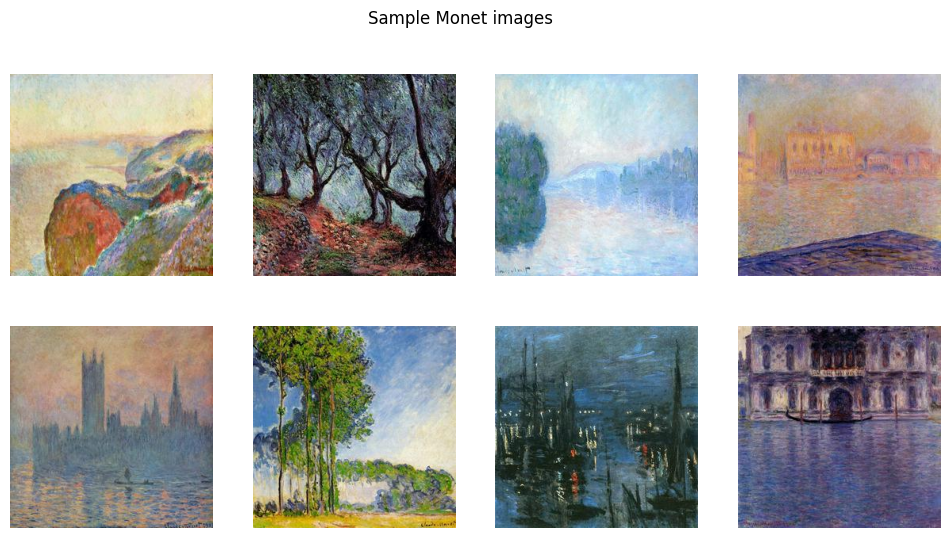

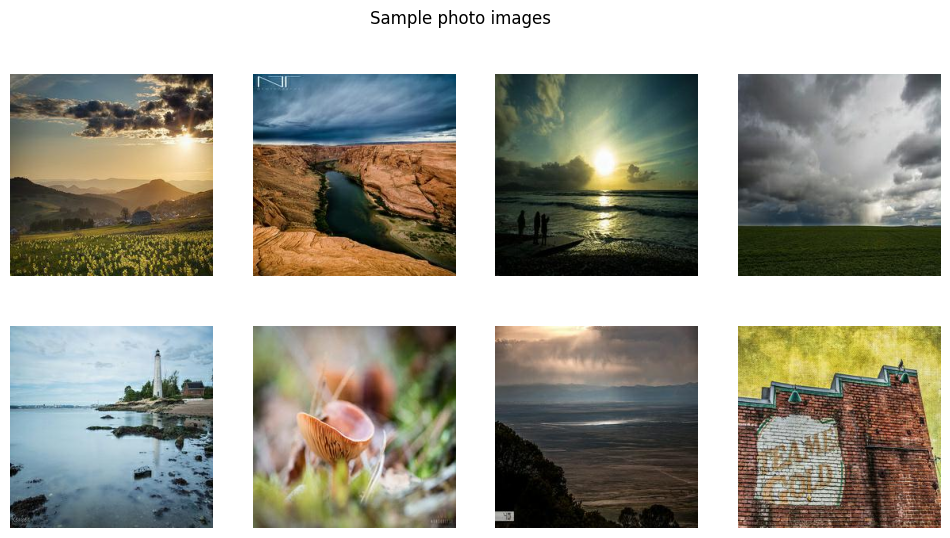

In [10]:
#showing grid of images :
def show_grid(files, title, n=8):
    plt.figure(figsize=(12, 6))
    for i, f in enumerate(files[:n]):
        img = Image.open(f)
        plt.subplot(2, n//2, i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_grid(monet_files, "Sample Monet images")
show_grid(photo_files, "Sample photo images")

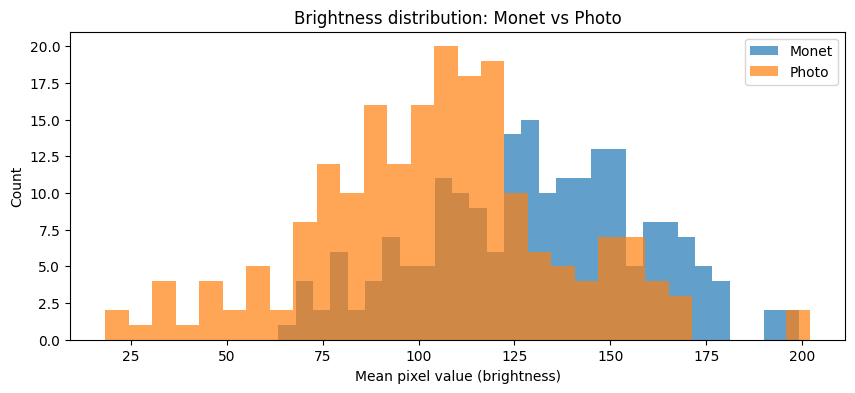

In [11]:
#histogram
def compute_brightness(files, max_images=200):
    vals = []
    for f in files[:max_images]:
        img = Image.open(f).convert("L")  # grayscale
        vals.append(np.array(img).mean())
    return np.array(vals)

monet_brightness = compute_brightness(monet_files)
photo_brightness = compute_brightness(photo_files)

plt.figure(figsize=(10,4))
plt.hist(monet_brightness, bins=30, alpha=0.7, label="Monet")
plt.hist(photo_brightness, bins=30, alpha=0.7, label="Photo")
plt.xlabel("Mean pixel value (brightness)")
plt.ylabel("Count")
plt.legend()
plt.title("Brightness distribution: Monet vs Photo")
plt.show()

## Exploratory Data Analysis (EDA)
For this project I’m using the Kaggle “GAN Getting Started” dataset, which has Monet paintings in one folder and regular photos in another. I first counted how many images there are in each folder and then showed a small grid of random Monet images and random photos just to see what they look like. The Monet pictures clearly have softer colors and brush strokes, while the photos look sharp and realistic. I also checked some basic stats like image sizes and rough brightness to confirm that the images are not all the same size and that the Monet and photo sets really do have different visual styles.
### Data Cleaning & Preprocessing
Before training, I wrote a small function that reads each image from disk, decodes it as an RGB image, resizes it to 256×256, and then scales the pixel values from 0–255 into the range −1 to 1. I use this same function for both Monet and photo images so everything ends up with the same shape and value range. Then I build TensorFlow datasets from the file lists, map them through this preprocessing function, shuffle them, and batch them so they’re ready to feed into the GAN.
### Plan of Analysis
From the EDA I saw that the Monet set is small but clearly different in style from the photos, so I decided to train a convolutional GAN on **64×64** images instead of 256×256. This keeps the computation cheaper and also matches the resolution that Kaggle uses for evaluation. My plan is to use a generator that starts from random noise and tries to produce 64×64 Monet-style images, and a discriminator that learns to tell real Monet paintings from fake ones. I train these two networks together with an adversarial loss (a binary cross-entropy style setup where the discriminator tries to classify real vs fake and the generator tries to fool it). After the training I look at side-by-side grids of real Monet images and generated images to see how the style improved. Once I’m happy with the results, I use the trained generator to create 10,000 Monet-style images at 64×64 resolution, zip them as images.zip, and submit that file to Kaggle so they can compute the MiFID score for my model.

## Model Archetecture(Model building and training )

In [12]:
from tensorflow.keras import models, layers

discriminator = models.Sequential(
    [
        layers.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        16,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 675,265 (2.58 MB)

 Trainable params: 675,265 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:

LATENT_DIM = 128

def build_generator(latent_dim=LATENT_DIM):
    model = models.Sequential(
        [
            layers.Input(shape=(latent_dim,)),
            layers.Dense(8 * 8 * 256),
            layers.Reshape((8, 8, 256)),
            layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
            layers.LeakyReLU(negative_slope=0.2),
            # final 64x64x3 image, pixels in [-1, 1]
            layers.Conv2D(3, kernel_size=3, padding="same", activation="tanh"),
        ],
        name="generator",
    )
    return model

generator = build_generator()
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 16384)          │     2,113,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 256)    │     1,048,832 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 3)      │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,819,651 (14.57 MB)

 Trainable params: 3,819,651 (14.57 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)

In [15]:
EPOCHS = 40

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    for step, real_images in enumerate(monet_ds):
        batch_size = tf.shape(real_images)[0]
        # -----------------------------
        # 1. Train the discriminator
        # -----------------------------
        # Sample random points in latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, LATENT_DIM))
        # Generate fake images
        generated_images = generator(random_latent_vectors, training=True)

        # Combine fake and real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        # (here: 1 = fake, 0 = real)
        labels = tf.concat(
            [
                tf.ones((batch_size, 1)),   # generated (fake)
                tf.zeros((batch_size, 1)),  # real
            ],
            axis=0,
        )

        # Add random noise to the labels - important trick
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = discriminator(combined_images, training=True)
            d_loss = loss_fn(labels, predictions)

        grads = tape.gradient(d_loss, discriminator.trainable_weights)
        d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

        # -----------------------------
        # 2. Train the generator
        # -----------------------------
        # Sample random points in latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, LATENT_DIM))

        # Assemble labels that say "all real images"
        # (misleading labels:want the  generator to fool the discriminator)
        misleading_labels = tf.zeros((batch_size, 1))  # because I used 0 for real above

        # Train the generator
        with tf.GradientTape() as tape:
            fake_images = generator(random_latent_vectors, training=True)
            predictions = discriminator(fake_images, training=False)
            g_loss = loss_fn(misleading_labels, predictions)

        grads = tape.gradient(g_loss, generator.trainable_weights)
        g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))

        if step % 50 == 0:
            print(f"  step {step:4d}: d_loss={d_loss:.4f}, g_loss={g_loss:.4f}")


Epoch 1/40
  step    0: d_loss=0.7026, g_loss=0.6932
  step   50: d_loss=0.4134, g_loss=0.9703
  step  100: d_loss=0.9034, g_loss=0.6418
  step  150: d_loss=0.1030, g_loss=1.5395
  step  200: d_loss=1.0780, g_loss=2.3641
  step  250: d_loss=0.5397, g_loss=0.8812
Epoch 2/40
  step    0: d_loss=0.2915, g_loss=1.1677
  step   50: d_loss=0.4675, g_loss=1.0546
  step  100: d_loss=0.2966, g_loss=0.6549
  step  150: d_loss=0.2815, g_loss=1.8677
  step  200: d_loss=0.5152, g_loss=0.1834
  step  250: d_loss=0.2003, g_loss=2.8605
Epoch 3/40
  step    0: d_loss=0.4531, g_loss=1.3484
  step   50: d_loss=0.5355, g_loss=1.8472
  step  100: d_loss=0.4940, g_loss=0.5800
  step  150: d_loss=0.4456, g_loss=0.3819
  step  200: d_loss=0.4429, g_loss=0.5396
  step  250: d_loss=0.5943, g_loss=1.5696
Epoch 4/40
  step    0: d_loss=0.9465, g_loss=0.4933
  step   50: d_loss=1.1880, g_loss=0.9559
  step  100: d_loss=0.2845, g_loss=0.6348
  step  150: d_loss=0.7178, g_loss=1.4532
  step  200: d_loss=0.5858, g_lo

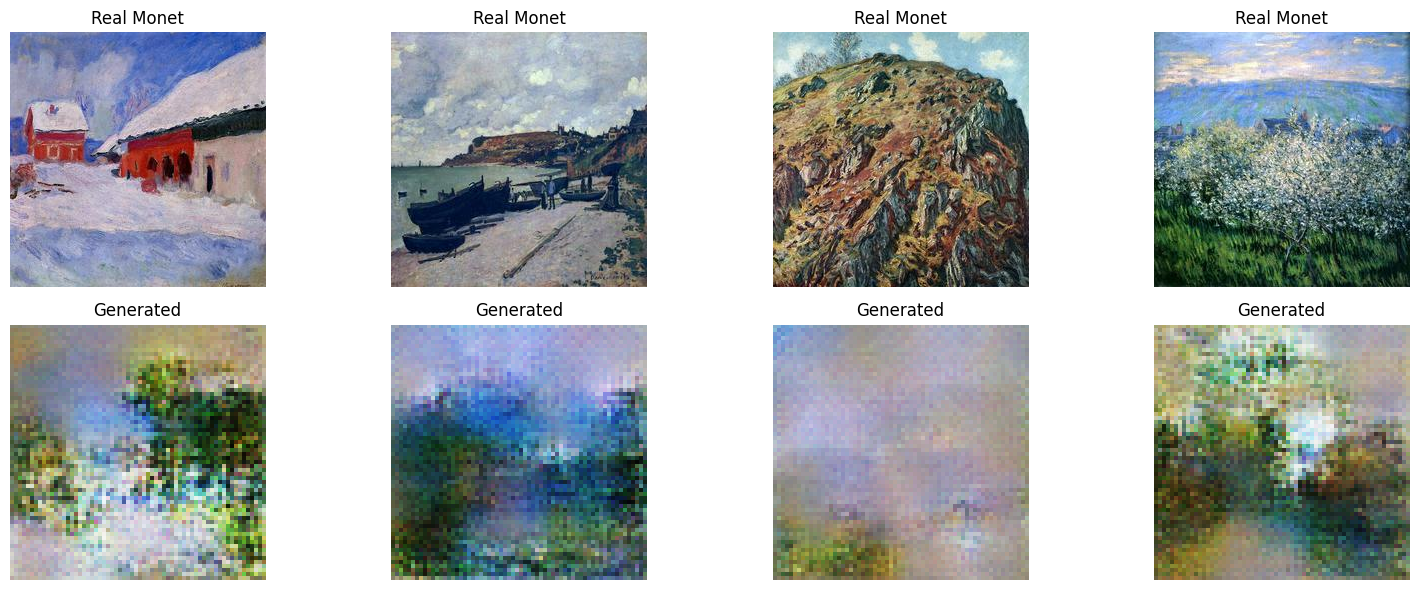

In [16]:
#### real vs. generated photo comparison

import matplotlib.pyplot as plt
from PIL import Image
import random
import numpy as np

def show_real_vs_generated(n=4):
    # 1) Pick n random real Monet images
    real_paths = random.sample(monet_files, n)
    real_imgs = []
    for path in real_paths:
        img = Image.open(path).convert("RGB")
        img = img.resize((256, 256))
        real_imgs.append(np.array(img))

    # 2) Generate n fake Monet images
    z = tf.random.normal(shape=(n, LATENT_DIM))
    fake_images = generator(z, training=False)
    # scale back from [-1, 1] to [0, 1] for display
    fake_images = (fake_images + 1.0) / 2.0
    fake_images = fake_images.numpy()

    # 3) Plot: top row = real, bottom row = generated
    plt.figure(figsize=(4 * n, 6))
    for i in range(n):
        # top row: real
        plt.subplot(2, n, i + 1)
        plt.imshow(real_imgs[i])
        plt.title("Real Monet")
        plt.axis("off")

        # bottom row: generated
        plt.subplot(2, n, n + i + 1)
        plt.imshow(fake_images[i])
        plt.title("Generated")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# call it
show_real_vs_generated(n=4)


## Results:
After training the DCGAN on Monet images resized to **64×64**, I looked at both the printed losses and the pictures it produced. Early in training, the discriminator and generator losses still bounced around a lot, which is normal for GANs, but over time they settled into a more reasonable range instead of exploding or collapsing. When I compared real Monet paintings in the top row with generated images in the bottom row, the fake images no longer looked like random noise. They started to pick up Monet-like color palettes and soft, brushy textures, even though the resolution was lower. At the same time, most generated images were still fuzzy and abstract, and they did not yet show clear objects or strong scene structure like boats, buildings, or people. They look more like rough, low-resolution “blobs” that capture some of the artistic feel but not the full content of a Monet painting.

## Conclusion
This mini-project did reach the basic goal of learning some aspects of Monet’s style using a DCGAN. The generator can now transform random noise into images that roughly match Monet’s soft colors and painterly textures, and the behavior of the losses suggests that the adversarial training loop is working as intended. However, the limitations are still obvious: even with the move to 64×64 resolution and multiple epochs of training, the results remain blurry and abstract, and they do not consistently form recognizable scenes like the real Monet examples. **To push the images closer to real Monet paintings I would try several things**:
- I would keep working at 64×64 resolution.
- Training longer on a GPU so the model sees the data many more times
- Tuning the learning rates or trying different optimizers such as **RMSprop**,
- Increasing the capacity of the generator and discriminator so they can learn more detailed patterns.

If I went further, I would also look at more advanced GAN variants (for example, models designed specifically for image-to-image style transfer) that are known to produce sharper, more realistic images.

In [17]:
#kaggle submission
import os
import io
import zipfile
from PIL import Image
import tensorflow as tf

NUM_IMAGES = 10000
ZIP_NAME = "images.zip"

def make_submission_zip(num_images=NUM_IMAGES, zip_name=ZIP_NAME):
    with zipfile.ZipFile(zip_name, mode="w") as zf:
        for i in range(num_images):
            # 1. Sample latent noise
            z = tf.random.normal(shape=(1, LATENT_DIM))
            # 2. Generate fake image (your generator outputs 256x256x3 in [-1, 1])
            fake = generator(z, training=False)[0]

            # 3. Scale back to [0, 255]
            img = (fake + 1.0) * 127.5
            img = tf.clip_by_value(img, 0, 255)
            img = tf.cast(img, tf.uint8).numpy()

            # 4. Convert to PIL, resize to 64x64 (Kaggle requirement), save as PNG
            pil_img = Image.fromarray(img)
            pil_img = pil_img.resize((64, 64))  # <-- 64x64x3 required

            buf = io.BytesIO()
            pil_img.save(buf, format="PNG")
            img_bytes = buf.getvalue()

            # 5. Write into the zip as image_00000.png, image_00001.png, ...
            filename = f"image_{i:05d}.png"
            zf.writestr(filename, img_bytes)

            if i % 1000 == 0:
                print(f"Saved {i} images...")

    print(f"Created {zip_name} with {num_images} images.")

make_submission_zip()



Saved 0 images...
Saved 1000 images...
Saved 2000 images...
Saved 3000 images...
Saved 4000 images...
Saved 5000 images...
Saved 6000 images...
Saved 7000 images...
Saved 8000 images...
Saved 9000 images...
Created images.zip with 10000 images.
